In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from plot_functions import return_list, plot_chains, plot_chain_zscore
import matplotx as mplx

In [ ]:
def plot_three_metrics(data_dict_all, chain_name, window_size=30, threshold=2):
    """
    Plot three metrics (fee, TVL'/Price, and Price) for a given chain on a single figure.
    The x-axis (date) is shared across all three subplots.

    Parameters:
    - data_dict_all (dict): Dictionary containing all data.
    - chain_name (str): The name of the chain to plot.
    - window_size (int): The window size for the rolling mean and standard deviation.
    - threshold (int): The Z-score threshold for anomaly detection.
    """
    # Check if all required data exists
    if 'fee' not in data_dict_all or 'tvl' not in data_dict_all or 'price' not in data_dict_all:
        print("Missing one or more required datasets (fee, tvl, price) in data_dict_all.")
        return

    if chain_name not in data_dict_all['fee'] or chain_name not in data_dict_all['tvl'] or chain_name not in data_dict_all['price']:
        print(f"Data for chain {chain_name} is missing in one or more datasets.")
        return

    # Prepare data
    fee_df = data_dict_all['fee'][chain_name].copy().tail(365*2+window_size)
    tvl_df = data_dict_all['tvl'][chain_name].copy().tail(365*2+window_size)
    price_df = data_dict_all['price'][chain_name].copy().tail(365*2+window_size)
    
    # rename the value column to avoid confusion
    fee_df.rename(columns={'value': 'value_fee'}, inplace=True)
    tvl_df.rename(columns={'value': 'value_tvl'}, inplace=True)
    price_df.rename(columns={'value': 'value_price'}, inplace=True)


    # Merge all data on the 'date' column
    merged_df = fee_df.merge(tvl_df, on='date', suffixes=('_fee', '_tvl'))
    merged_df = merged_df.merge(price_df, on='date')

    # Compute TVL'/Price
    merged_df['tvl_prime'] = merged_df['value_tvl'] / merged_df['value_price']

    # Compute rolling statistics for tvl'
    merged_df['rolling_mean'] = merged_df['tvl_prime'].rolling(window=window_size).mean()
    merged_df['rolling_std'] = merged_df['tvl_prime'].rolling(window=window_size).std()
    merged_df['Z_score'] = (merged_df['tvl_prime'] - merged_df['rolling_mean']) / merged_df['rolling_std']
    merged_df['is_anomaly'] = merged_df['Z_score'].abs() > threshold

    # Apply dark background style
    plt.style.use("dark_background")

    for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
        plt.rcParams[param] = '0.9'  # very light grey

    for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
        plt.rcParams[param] = '#212946'  # bluish dark grey

    colors = [
        '#08F7FE',  # teal/cyan
        '#FE53BB',  # pink
        '#F5D300',  # yellow
        '#00ff41',  # matrix green
    ]

    fig, axes = plt.subplots(3, 1, figsize=(14, 14), sharex=True, gridspec_kw={'hspace': 0.1})


    # Plot Fee
    axes[0].plot(merged_df['date'], merged_df['value_fee'], color=colors[0], linewidth=1)
    axes[0].fill_between(merged_df['date'], merged_df['value_fee'], color=colors[0], alpha=0.1)
    axes[0].set_title(f'Fee Over Time', loc='left', fontsize=14, fontweight='bold')

    # Plot TVL' with anomalies
    axes[1].plot(merged_df['date'], merged_df['tvl_prime'], color=colors[1], linewidth=1, label="TVL'")
    axes[1].fill_between(merged_df['date'], merged_df['tvl_prime'], color=colors[1], alpha=0.1)
    axes[1].plot(merged_df['date'], merged_df['rolling_mean'], color=colors[2], linestyle='--', linewidth=1, label=f'{window_size}-day Rolling Mean')

    # Highlight anomalies
    anomalies = merged_df[merged_df['is_anomaly']]
    axes[1].scatter(anomalies['date'], anomalies['tvl_prime'], color=colors[3], s=30, edgecolor='black', label='Anomalies', zorder=5)

    axes[1].set_title(f"TVL' Over Time with Anomalies", loc='left', fontsize=14, fontweight='bold')

    # Plot Price
    axes[2].plot(merged_df['date'], merged_df['value_price'], color=colors[2], linewidth=1)
    axes[2].fill_between(merged_df['date'], merged_df['value_price'], color=colors[2], alpha=0.1)
    axes[2].set_title(f'Price Over Time', loc='left', fontsize=14, fontweight='bold')

    # Format plots
    for ax in axes:
        ax.grid(color='#2A3459')
        ax.set_xlim([merged_df['date'].iloc[0], merged_df['date'].iloc[-1]])
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.set_facecolor('#212946')
    
    output_folder = './results/z_score_charts'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # plt.savefig(os.path.join(output_folder, f'{chain_name}_tvl\'.png'))
    print(f"{chain_name} TVL' Z-Score chart with Price has been saved ({chain_name}_3.png)")
    
    plt.tight_layout()
    plt.show()

         name           tvl
15   Ethereum  7.286474e+10
47     Solana  8.849683e+09
92       Tron  7.336604e+09
4         BSC  5.468444e+09
13       Base  3.833646e+09
54    Bitcoin  3.467905e+09
17   Arbitrum  3.242048e+09
95        Sui  1.559820e+09
11  Avalanche  1.462444e+09
18    Polygon  1.116314e+09
59      Aptos  1.112267e+09


C:\Users\YuweiCao\AppData\Local\Temp\ipykernel_8884\3643941491.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


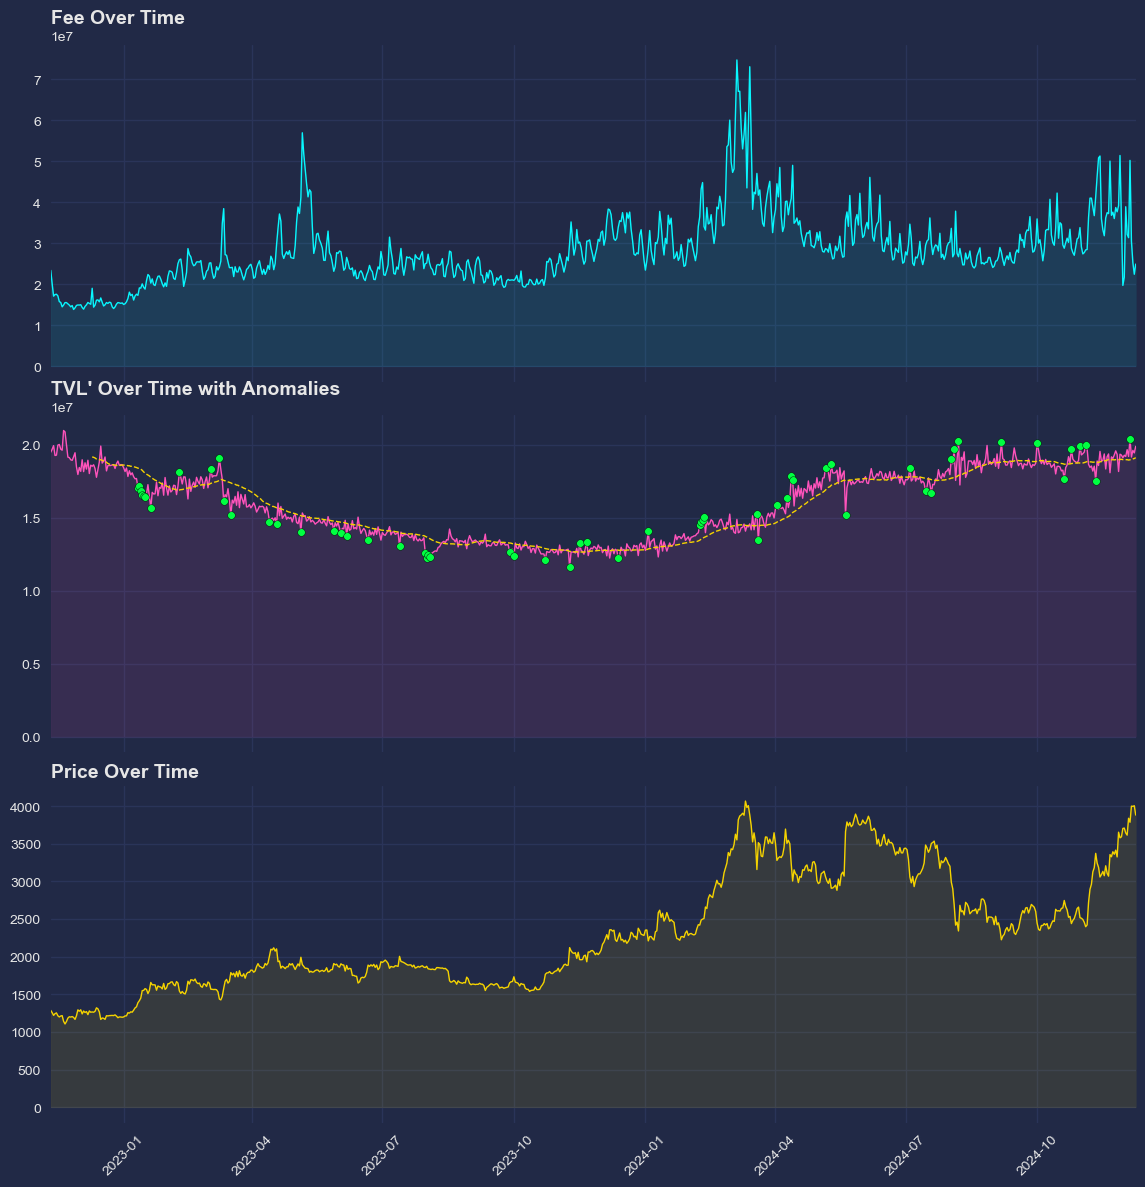

In [53]:
name_list = return_list() # get the name list of the chains

data_folder = 'data'
subfolders = ['fee', 'tvl', 'volume', 'price']

data_dict = {} # this one is for the last 365*2 days
data_dict_all = {} # this one is for all data, cuz we need to compute z-score

# read data
for subfolder in subfolders:
    folder_path = os.path.join(data_folder, subfolder)
    if os.path.exists(folder_path):
        csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])

        data_dict[subfolder] = {}
        data_dict_all[subfolder] = {}

        for csv_file in csv_files:
            chain_name = csv_file.split('_')[1]

            csv_path = os.path.join(folder_path, csv_file)
            df = pd.read_csv(csv_path)

            df.columns = ['date', 'value'] if subfolder == 'fee' else ['date', subfolder]
            df.rename(columns={subfolder: 'value'}, inplace=True)
            df['date'] = pd.to_datetime(df['date'])

            data_dict[subfolder][chain_name] = df.tail(365*2)
            data_dict_all[subfolder][chain_name] = df


# for name in name_list['name']:
#     if name == 'Base':
#         continue
#     plot_tvl_zscore(data_dict_all, chain_name=name)

# plot_tvl_zscore(data_dict_all, chain_name='Ethereum')

plot_three_metrics(data_dict_all, chain_name='Ethereum')

